# Quantum Phase Estimation Lab

## Objectives

Apply acquired knowledge to implement the Quantum Phase Estimation (QPE) algorithm and determine the phase of a unitary operator $U$. This will be done using the QISKit development environment, Quantum Lab.

## Exercise:

QPE (Quantum Phase Estimation), also known as PEA (Phase Estimation Algorithm), is an algorithm that allows determining the eigenvalues of a unitary operator. It finds applications in various quantum computing problems and stands as one of the key subroutines in quantum computation.

![Algorithm Overview](Resources/QPE.png)

The unitary condition of linear transformations applied to quantum states is a requirement of quantum mechanics. As the operator $U$ is unitary $(U^† U=I)$, its eigenvalues have a modulus of 1 and can be expressed in the form $e^{iθ}$, where $θ$ is the phase associated with the eigenvalue.

Since $θ∈[0,2π)$, we can represent θ as a fraction of 2π, i.e., $θ=θ' (2π)$, where $θ^∈[0,1)$. As $θ'$ is a decimal between 0 and 1, it can be represented as a binary fraction: $θ'=0.θ_1 θ_2 θ_3...θ_n$, where n is the desired precision.

The algorithm's general scheme involves using Phase Kickback to modify the phase of control qubits, storing the phase in the Fourier basis, and then applying the inverse Quantum Fourier Transform (QFT) to convert to the computational basis for measurement.

Some binary fractions examples:

- $1/4 = 0.25 ⇒ 0.010$
- $1/8 = 0.125 ⇒ 0.001$
- $1/6 = 0.1666... ⇒ 0.0010101...$
- $1/3 = 0.3333... ⇒ 0.01010101...$

The goal of this exercise is to accurately estimate the phase of the unitary operator $U$, which applies a rotation of $π⁄9$ around the Z-axis to the state $|1⟩:
U|1⟩=e^{(iπ/9)} |1⟩$

## Development

### 1. Import the necessary libraries

We will start by importing the necessary libraries for this exercise. We will use the QISKit library to create the quantum circuits and execute them on the simulator and the IBMQ Experience devices.


In [24]:
# Import necessary liobraries

import numpy as np 

import qiskit as qk

from qiskit import Aer, execute

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

from qiskit.tools.visualization import plot_histogram

from qiskit.circuit.library import QFT

### 2. Implement the Quantum Phase Estimation algorithm

At this point, we will implement the QPE algorithm. The algorithm consists of the following steps:

- Apply a Hadamard gate to the first 3 qubits. These qubits will be used to store the phase.
- Initialize the fourth qubit to the $|\psi⟩$ state. This state will be an eigenstate of the unitary operator $U$ we are evaluating. In this case we will use the state $|1⟩$.
- Apply the controlled unitary operator $U^{1}, U^{2}, U^{4}$ to the fourth qubit, controlled by the first, second, and third qubits, respectively. This will use phase kickback to store the phase of the eigenstate in the first three qubits.
- Apply the inverse Quantum Fourier Transform to the first three qubits.
- Measure the first three qubits.

For the implementation of the $U$ operator we will use the $CRZGate$ class, which implements a single-qubit rotation around the Z axis controlled by a qubit. The $RCZGate$ class has a parameter called $theta$, which represents the rotation angle. We will use this parameter to implement the $U$ operator.

Once we have the algorithm implemented, we will execute it on the simulator and the IBMQ Experience devices.

Based on the results obtained, we will determine the phase of the unitary operator $U$.


In [123]:
# Define the function to create the quantum phase estimation circuit
def qpe(theta, qubits,backend=Aer.get_backend('qasm_simulator'), shots=1024):
    """
    Creates a Quantum Phase Estimation (QPE) circuit and estimates the phase of a unitary operator U.

    Parameters:
    - theta (float): The angle of the rotation gate.
    - qubits (int): The number of qubits used in the quantum phase estimation circuit.

    Returns:
    tuple: (QuantumCircuit, dict, float, str)
        - QuantumCircuit: The quantum phase estimation circuit.
        - dict: Measurement results from executing the circuit.
        - float: The estimated phase of the unitary operator U.
        - str: The binary representation of the measured phase.

    The QPE circuit estimates the phase of a unitary operator U that applies a rotation
    with respect to the Z-axis by the specified angle (theta).

    Circuit Structure:
    1. Applies Hadamard gates to the first qubits.
    2. Initializes the last qubit to |1>.
    3. Applies controlled Rz gates based on the specified angle.
    4. Applies the inverse Quantum Fourier Transform (QFT).
    5. Performs measurements on the qubits.

    Example:
    ```python
    theta_value = 0.523
    qubits_used = 3
    my_qpe_circuit, measurement_results, estimated_phase, binary_representation = qpe(theta_value, qubits_used)
    ```

    Note: This function uses QuantumCircuit, QFT, numpy, math, and execute from the Qiskit library.

    """
    # Create the quantum phase estimation circuit
    qpe = QuantumCircuit(qubits + 1, qubits)

    # Apply the Hadamard gate to the first qubits
    for qubit in range(qubits):
        qpe.h(qubit)

    # Initialize the last qubit to |1>
    qpe.x(qubits)

    # Apply controlled Rz gates
    for qubit in range(qubits):
        qpe.crz(theta * 2**(qubit + 1), qubit, qubits)

    # Apply the inverse QFT
    qft_1 = QFT(qubits, 0, True, True)
    qpe.compose(qft_1, inplace=True)

    # Apply the measurement
    for qubit in range(qubits):
        qpe.measure(qubit, qubit)

    # Execute the circuit and get measurement results
    results = execute(qpe, backend=backend, shots=shots).result()
    answer = results.get_counts()

    def phase_from_counts(counts):
        """
        Calculates the phase from the measurement results of a QPE circuit.

        Parameters:
        - counts (dict): The measurement results of a QPE circuit.

        Returns:
        tuple: (float, str)
            - float: The phase of the unitary operator U.
            - str: The binary representation of the measured phase.

        The QPE circuit estimates the phase of a unitary operator U that applies a rotation
        with respect to the Z-axis by the specified angle (theta).

        Example:
        ```python
        theta_value = 0.523
        qubits_used = 3
        my_qpe_circuit = qpe(theta_value, qubits_used)
        my_counts = execute(my_qpe_circuit, backend=backend, shots=shots).result().get_counts()
        my_phase, my_binary = phase_from_counts(my_counts)
        ```

        Note: This function uses numpy and math.

        """
        # Calculate the phase from the measurement results
        binary_number = max(counts, key=counts.get)
        phase = 2* np.pi * int(binary_number, 2)/(2**qubits)
        return phase, binary_number

    # Obtain phase and binary representation from counts
    phase, binary_number = phase_from_counts(answer)

    return qpe, answer, phase, binary_number


Let's print an example QPE circuit for $U = RZ(π/9)$:


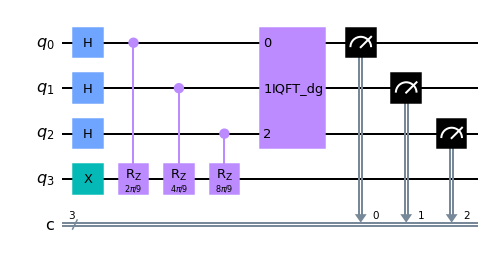

In [124]:
# Define the quantum circuit to implement QPE
theta = np.pi/9
qubits = 3

# Draw the quantum circuit
circuit = qpe(theta, qubits)[0]
circuit.draw(output='mpl')

### 3. Execute the quantum circuit and evaluate the results

We will now execute the circuit and evaluate the results. We will use the `qasm_simulator` as a backend to execute the circuit. We will execute the circuit 1024 times to obtain the statistics of the results.

We will evaluate the results using different numbers of qubits to store the phase. We will use 3, 5, 10 and 15 qubits. The number of qubits used to store the phase will determine the precision of the result. The more qubits we use, the more precise the result will be.

In [125]:
# Define the quantum circuit to implement QPE
theta = np.pi/9

# Print expected phase
print('The expected phase is', theta)

# List of qubit values to evaluate
evaluations = [3,5,10,15]

# Iterate over the qubit values
for qubit in evaluations:

    circuit,count,phase,binary_number = qpe(theta, qubit)
    print('The phase is', phase, 'related to the binary number', binary_number)


The expected phase is 0.3490658503988659
The phase is 0.0 related to the binary number 000
The phase is 0.39269908169872414 related to the binary number 00010
The phase is 0.34974761963792617 related to the binary number 0000111001
The phase is 0.3489806292439834 related to the binary number 000011100011100


As we can see, the more qubits we use, the more precise the result is. In this case, we will use 15 qubits to store the phase, which gives us a precision of 15 bits.